# Week 4: Using real world data

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week4/Labs/C4W4_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In [1]:
%%bash

# If running in Google Colab

# mkdir data
# wget https://raw.githubusercontent.com/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/main/Sequences_Time_Series_and_Prediction/Week4/Labs/data/daily-min-temperatures.csv -P ./data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete some of the cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the locked cells, you may follow the instructions at the bottom of this notebook._

In [2]:
import csv
import numpy as np
import tensorflow as tf
from keras import Sequential, Input, layers, optimizers, losses, callbacks, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

2024-06-14 15:01:22.717987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Begin by looking at the structure of the csv that contains the data:

In [3]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    sns.set_style("whitegrid")
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [5]:
def parse_data_from_file(filename):
    times = []
    temperatures = []

    with open(filename) as csvfile:
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        
        for row in reader:
            times.append(row[0])
            temperatures.append(float(row[1]))
        ### END CODE HERE
            
    return times, temperatures

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

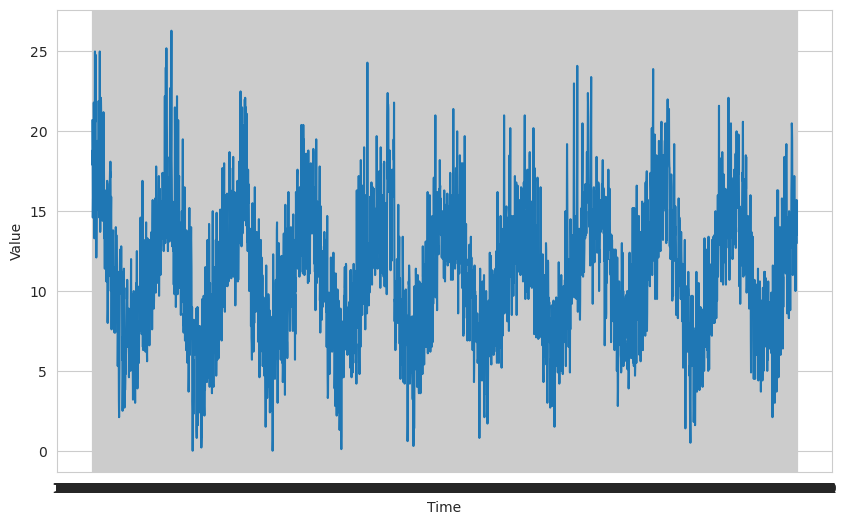

In [6]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Expected Output:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [7]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

2024-06-14 15:01:45.103747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2177 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [9]:
def create_uncompiled_model():
    ### START CODE HERE
    
    model = Sequential([Input(shape=(None, 1)),
                        layers.Conv1D(filters=128, kernel_size=3, strides=1, activation="relu", padding="causal"), 
                        layers.LSTM(64, return_sequences=True),
                        layers.LSTM(64),
                        layers.Dense(30, activation="relu"),
                        layers.Dense(10, activation="relu"),
                        layers.Dense(1)]) 
    
    ### END CODE HERE

    return model

You can test your model with the code below. If you get an error, it's likely that your model is returning a sequence. You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. You can review the lectures or the previous ungraded labs to see how that is done.

In [10]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                 f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Your current architecture is compatible with the windowed dataset! :)


2024-06-14 15:01:45.640479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-14 15:01:45.813558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [11]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()
    
    lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [12]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.0821 - mae: 10.5813 - learning_rate: 1.0000e-04
Epoch 2/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8083 - mae: 9.3066

2024-06-14 15:01:49.266876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:49.266925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4299 - mae: 8.9278 - learning_rate: 1.1220e-04
Epoch 3/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7525 - mae: 7.2426

2024-06-14 15:01:49.807765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:49.807791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:49.807807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0427 - mae: 6.5318 - learning_rate: 1.2589e-04
Epoch 4/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0880 - mae: 4.5622

2024-06-14 15:01:50.342657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:50.342682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8311 - mae: 4.3041 - learning_rate: 1.4125e-04
Epoch 5/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9845 - mae: 3.4592

2024-06-14 15:01:50.922114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:50.922145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:50.922156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8852 - mae: 3.3553 - learning_rate: 1.5849e-04
Epoch 6/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7016 - mae: 3.1653

2024-06-14 15:01:51.457309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:51.457370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:51.457379: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4587 - mae: 2.9194 - learning_rate: 1.7783e-04
Epoch 7/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1730 - mae: 2.6241

2024-06-14 15:01:52.017482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:52.017542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:52.017551: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9820 - mae: 2.4324 - learning_rate: 1.9953e-04
Epoch 8/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1952 - mae: 2.6522

2024-06-14 15:01:52.572402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:52.572587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9681 - mae: 2.4229 - learning_rate: 2.2387e-04
Epoch 9/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8550 - mae: 2.3058

2024-06-14 15:01:53.124130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:53.124177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:01:53.124194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7994 - mae: 2.2493 - learning_rate: 2.5119e-04
Epoch 10/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8757 - mae: 2.3230

2024-06-14 15:01:53.707939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:53.707965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:53.707974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8535 - mae: 2.3036 - learning_rate: 2.8184e-04
Epoch 11/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8469 - mae: 2.3037

2024-06-14 15:01:54.265483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:54.265545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:54.265558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7472 - mae: 2.1988 - learning_rate: 3.1623e-04
Epoch 12/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9287 - mae: 2.3822

2024-06-14 15:01:54.832018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:54.832045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:54.832056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7484 - mae: 2.1964 - learning_rate: 3.5481e-04
Epoch 13/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7941 - mae: 2.2555

2024-06-14 15:01:55.391534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:55.391564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:55.391573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6635 - mae: 2.1145 - learning_rate: 3.9811e-04
Epoch 14/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6800 - mae: 2.1252

2024-06-14 15:01:55.979476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:55.979509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:55.979519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5838 - mae: 2.0250 - learning_rate: 4.4668e-04
Epoch 15/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6420 - mae: 2.0785

2024-06-14 15:01:56.526822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:56.526860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:56.526870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5829 - mae: 2.0209 - learning_rate: 5.0119e-04
Epoch 16/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5066 - mae: 1.9567

2024-06-14 15:01:57.078112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:57.078142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:57.078154: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5429 - mae: 1.9897 - learning_rate: 5.6234e-04
Epoch 17/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6805 - mae: 2.1231

2024-06-14 15:01:57.632629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:57.632652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:57.632660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6247 - mae: 2.0688 - learning_rate: 6.3096e-04
Epoch 18/100
 9/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8237 - mae: 2.2816  

2024-06-14 15:01:58.188623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:58.188656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5787 - mae: 2.0272 - learning_rate: 7.0795e-04
Epoch 19/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5957 - mae: 2.0366

2024-06-14 15:01:58.779831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:58.779857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:58.779868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5291 - mae: 1.9717 - learning_rate: 7.9433e-04
Epoch 20/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7634 - mae: 2.2181

2024-06-14 15:01:59.322309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:59.322338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:59.322349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6314 - mae: 2.0781 - learning_rate: 8.9125e-04
Epoch 21/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5176 - mae: 1.9621

2024-06-14 15:01:59.860725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:01:59.860763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:01:59.860772: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5392 - mae: 1.9844 - learning_rate: 0.0010
Epoch 22/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6029 - mae: 2.0514

2024-06-14 15:02:00.395538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:00.395559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:00.395570: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5737 - mae: 2.0206 - learning_rate: 0.0011
Epoch 23/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5311 - mae: 1.9762

2024-06-14 15:02:00.933188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:00.933226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5148 - mae: 1.9573 - learning_rate: 0.0013
Epoch 24/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5485 - mae: 1.9947

2024-06-14 15:02:01.464484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:01.464505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:01.464514: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5380 - mae: 1.9810 - learning_rate: 0.0014
Epoch 25/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4277 - mae: 1.8627

2024-06-14 15:02:02.034457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:02.034482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:02.034493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4823 - mae: 1.9216 - learning_rate: 0.0016
Epoch 26/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5670 - mae: 2.0127

2024-06-14 15:02:02.565477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:02.565545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5683 - mae: 2.0130 - learning_rate: 0.0018
Epoch 27/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8060 - mae: 2.2573

2024-06-14 15:02:03.095254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:03.095274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6837 - mae: 2.1301 - learning_rate: 0.0020
Epoch 28/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8588 - mae: 2.3190

2024-06-14 15:02:03.628521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:03.628578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6855 - mae: 2.1379 - learning_rate: 0.0022
Epoch 29/100
16/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6789 - mae: 2.1329

2024-06-14 15:02:04.156865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:04.156891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:04.156898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6490 - mae: 2.1005 - learning_rate: 0.0025
Epoch 30/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4924 - mae: 1.9363

2024-06-14 15:02:04.768258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:04.768280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:04.768288: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5292 - mae: 1.9731 - learning_rate: 0.0028
Epoch 31/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4669 - mae: 1.9076

2024-06-14 15:02:05.318600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:05.318622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5123 - mae: 1.9548 - learning_rate: 0.0032
Epoch 32/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5681 - mae: 2.0093

2024-06-14 15:02:05.873426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:05.873450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:05.873458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5525 - mae: 1.9937 - learning_rate: 0.0035
Epoch 33/100
14/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7698 - mae: 2.2237 

2024-06-14 15:02:06.425481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:06.425507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:06.425518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6880 - mae: 2.1397 - learning_rate: 0.0040
Epoch 34/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6862 - mae: 2.1261

2024-06-14 15:02:07.002803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:07.002877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5959 - mae: 2.0361 - learning_rate: 0.0045
Epoch 35/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5136 - mae: 1.9513

2024-06-14 15:02:07.567522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:07.567543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5055 - mae: 1.9445 - learning_rate: 0.0050
Epoch 36/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9009 - mae: 2.3634

2024-06-14 15:02:08.123918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:08.123944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:08.123953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7007 - mae: 2.1522 - learning_rate: 0.0056
Epoch 37/100
14/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8666 - mae: 2.3131

2024-06-14 15:02:08.676477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:08.676501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:08.676510: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6798 - mae: 2.1237 - learning_rate: 0.0063
Epoch 38/100
16/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5844 - mae: 2.0297

2024-06-14 15:02:09.256659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:09.256683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6166 - mae: 2.0612 - learning_rate: 0.0071
Epoch 39/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7153 - mae: 2.1616

2024-06-14 15:02:09.863157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:09.863180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:09.863198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6376 - mae: 2.0844 - learning_rate: 0.0079
Epoch 40/100
 8/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9267 - mae: 2.3726  

2024-06-14 15:02:10.438171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:10.438200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:10.438214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7330 - mae: 2.1798 - learning_rate: 0.0089
Epoch 41/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8196 - mae: 2.2787

2024-06-14 15:02:11.060043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:11.060073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:11.060137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6990 - mae: 2.1507 - learning_rate: 0.0100
Epoch 42/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4289 - mae: 2.8913

2024-06-14 15:02:11.632413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:11.632437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:11.632446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9375 - mae: 2.3898 - learning_rate: 0.0112
Epoch 43/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7294 - mae: 2.1768

2024-06-14 15:02:12.210868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:12.210896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:12.210910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6983 - mae: 2.1453 - learning_rate: 0.0126
Epoch 44/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0024 - mae: 2.4536

2024-06-14 15:02:12.767624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:12.767648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8731 - mae: 2.3248 - learning_rate: 0.0141
Epoch 45/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8743 - mae: 2.3179

2024-06-14 15:02:13.316901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:13.316928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:13.316941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8712 - mae: 2.3177 - learning_rate: 0.0158
Epoch 46/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6581 - mae: 2.1047

2024-06-14 15:02:13.870991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:13.871019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7245 - mae: 2.1740 - learning_rate: 0.0178
Epoch 47/100
 1/77 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 1.5769 - mae: 1.9828

2024-06-14 15:02:14.423825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:14.423849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:14.423858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6575 - mae: 2.1044 - learning_rate: 0.0200
Epoch 48/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7265 - mae: 2.1799

2024-06-14 15:02:15.051457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:15.051484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8318 - mae: 2.2853 - learning_rate: 0.0224
Epoch 49/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1025 - mae: 2.5618

2024-06-14 15:02:15.602516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:15.602540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:15.602549: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9389 - mae: 2.3924 - learning_rate: 0.0251
Epoch 50/100
 1/77 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 2.5724 - mae: 3.0475

2024-06-14 15:02:16.150804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:16.150840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 15:02:16.150862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10860398314026017056
2024-06-14 15:02:16.150875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11176134498103797767
2024-06-14 15:02:16.150887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8700 - mae: 2.3196 - learning_rate: 0.0282
Epoch 51/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9747 - mae: 2.4363

2024-06-14 15:02:16.804127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:16.804163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:16.804175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9236 - mae: 2.3801 - learning_rate: 0.0316
Epoch 52/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1897 - mae: 2.6459

2024-06-14 15:02:17.380495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:17.380518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:17.380586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1365 - mae: 2.5932 - learning_rate: 0.0355
Epoch 53/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2528 - mae: 2.7101

2024-06-14 15:02:17.944602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:17.944629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:17.944641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11176134498103797767
2024-06-14 15:02:17.944649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:17.944658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10860398314026017056


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4269 - mae: 2.8867 - learning_rate: 0.0398
Epoch 54/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9304 - mae: 3.4053

2024-06-14 15:02:18.513939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:18.513963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:18.513972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11176134498103797767
2024-06-14 15:02:18.513977: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:18.513983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10860398314026017056


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8821 - mae: 3.3538 - learning_rate: 0.0447
Epoch 55/100
15/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5033 - mae: 3.9684

2024-06-14 15:02:19.121289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:19.121313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:19.121322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0510 - mae: 3.5185 - learning_rate: 0.0501
Epoch 56/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9804 - mae: 3.4511

2024-06-14 15:02:19.725630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:19.725658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:19.725670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8682 - mae: 3.3385 - learning_rate: 0.0562
Epoch 57/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1073 - mae: 3.5765

2024-06-14 15:02:20.295517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:20.295546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:20.295558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0465 - mae: 3.5165 - learning_rate: 0.0631
Epoch 58/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7703 - mae: 3.2447

2024-06-14 15:02:20.901889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:20.901916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:20.901926: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7858 - mae: 3.2557 - learning_rate: 0.0708
Epoch 59/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9381 - mae: 3.4141

2024-06-14 15:02:21.481271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:21.481296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:21.481322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9044 - mae: 3.3767 - learning_rate: 0.0794
Epoch 60/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1109 - mae: 3.5831

2024-06-14 15:02:22.061091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:22.061114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:22.061124: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9215 - mae: 3.3902 - learning_rate: 0.0891
Epoch 61/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1328 - mae: 3.6052

2024-06-14 15:02:22.649587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:22.649610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9508 - mae: 3.4200 - learning_rate: 0.1000
Epoch 62/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4014 - mae: 3.8776

2024-06-14 15:02:23.217559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:23.217585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:23.217594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1212 - mae: 3.5935 - learning_rate: 0.1122
Epoch 63/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0090 - mae: 3.4789

2024-06-14 15:02:23.774941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:23.774966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9103 - mae: 3.3794 - learning_rate: 0.1259
Epoch 64/100
12/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8888 - mae: 3.3619

2024-06-14 15:02:24.318264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:24.318288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:24.318297: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8528 - mae: 3.3245 - learning_rate: 0.1413
Epoch 65/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9048 - mae: 3.3714

2024-06-14 15:02:24.916774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:24.916829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8796 - mae: 3.3471 - learning_rate: 0.1585
Epoch 66/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2577 - mae: 3.7306

2024-06-14 15:02:25.462618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:25.462680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9688 - mae: 3.4391 - learning_rate: 0.1778
Epoch 67/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0322 - mae: 3.5065

2024-06-14 15:02:26.005985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:26.006008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:26.006017: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8508 - mae: 3.3205 - learning_rate: 0.1995
Epoch 68/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0556 - mae: 3.5289

2024-06-14 15:02:26.569363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:26.569395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:26.569409: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9012 - mae: 3.3717 - learning_rate: 0.2239
Epoch 69/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0563 - mae: 3.5282

2024-06-14 15:02:27.125449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:27.125477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9433 - mae: 3.4130 - learning_rate: 0.2512
Epoch 70/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8942 - mae: 3.3658

2024-06-14 15:02:27.710022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:27.710046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:27.710058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8419 - mae: 3.3108 - learning_rate: 0.2818
Epoch 71/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7556 - mae: 3.2268

2024-06-14 15:02:28.285075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:28.285101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:28.285110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7473 - mae: 3.2162 - learning_rate: 0.3162
Epoch 72/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9466 - mae: 3.4163

2024-06-14 15:02:28.835699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:28.835730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:28.835745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8479 - mae: 3.3151 - learning_rate: 0.3548
Epoch 73/100
16/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0620 - mae: 3.5345

2024-06-14 15:02:29.457169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:29.457197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:29.457210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8643 - mae: 3.3326 - learning_rate: 0.3981
Epoch 74/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0496 - mae: 3.5246

2024-06-14 15:02:30.057714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:30.057776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8659 - mae: 3.3357 - learning_rate: 0.4467
Epoch 75/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8988 - mae: 3.3694

2024-06-14 15:02:30.627014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:30.627040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:30.627050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8156 - mae: 3.2839 - learning_rate: 0.5012
Epoch 76/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9755 - mae: 3.4430

2024-06-14 15:02:31.199461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:31.199485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:31.199508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8431 - mae: 3.3099 - learning_rate: 0.5623
Epoch 77/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9367 - mae: 3.4103

2024-06-14 15:02:31.796464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:31.796488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:31.796497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8274 - mae: 3.2963 - learning_rate: 0.6310
Epoch 78/100
 9/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8883 - mae: 3.3562 

2024-06-14 15:02:32.373964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:32.373995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:32.374038: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11176134498103797767
2024-06-14 15:02:32.374051: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:32.374060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10860398314026017056


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8394 - mae: 3.3081 - learning_rate: 0.7079
Epoch 79/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0197 - mae: 3.4971

2024-06-14 15:02:32.969048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:32.969075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:32.969085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8423 - mae: 3.3141 - learning_rate: 0.7943
Epoch 80/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0982 - mae: 3.5667

2024-06-14 15:02:33.547649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:33.547679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:33.547690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8419 - mae: 3.3079 - learning_rate: 0.8913
Epoch 81/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8116 - mae: 3.2756

2024-06-14 15:02:34.164112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:34.164138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:34.164149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8027 - mae: 3.2690 - learning_rate: 1.0000
Epoch 82/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8451 - mae: 3.3218

2024-06-14 15:02:34.730824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:34.730860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:34.730876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8387 - mae: 3.3097 - learning_rate: 1.1220
Epoch 83/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0462 - mae: 3.5233

2024-06-14 15:02:35.278663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:35.278689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8902 - mae: 3.3607 - learning_rate: 1.2589
Epoch 84/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1370 - mae: 3.6008

2024-06-14 15:02:35.820403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:35.820425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:35.820434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9762 - mae: 3.4432 - learning_rate: 1.4125
Epoch 85/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8641 - mae: 3.3335

2024-06-14 15:02:36.378530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:36.378555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:36.378565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8446 - mae: 3.3143 - learning_rate: 1.5849
Epoch 86/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0044 - mae: 3.4626

2024-06-14 15:02:36.917010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:36.917036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:36.917045: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8882 - mae: 3.3533 - learning_rate: 1.7783
Epoch 87/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0798 - mae: 3.5441

2024-06-14 15:02:37.514419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:37.514446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:37.514458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9248 - mae: 3.3899 - learning_rate: 1.9953
Epoch 88/100
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9415 - mae: 3.4134

2024-06-14 15:02:38.061345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:38.061372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:38.061404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8635 - mae: 3.3338 - learning_rate: 2.2387
Epoch 89/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2007 - mae: 3.6786

2024-06-14 15:02:38.683939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:38.683971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:38.683983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0119 - mae: 3.4845 - learning_rate: 2.5119
Epoch 90/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0150 - mae: 3.4903

2024-06-14 15:02:39.261887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:39.261912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9053 - mae: 3.3754 - learning_rate: 2.8184
Epoch 91/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3646 - mae: 3.8405

2024-06-14 15:02:39.842458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:39.842488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:39.842500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0113 - mae: 3.4814 - learning_rate: 3.1623
Epoch 92/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0111 - mae: 3.4778

2024-06-14 15:02:40.403004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:40.403032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:40.403044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9679 - mae: 3.4370 - learning_rate: 3.5481
Epoch 93/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1112 - mae: 3.5837

2024-06-14 15:02:40.975012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:40.975039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:40.975049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9095 - mae: 3.3799 - learning_rate: 3.9811
Epoch 94/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1315 - mae: 3.6068

2024-06-14 15:02:41.580957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:41.580980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9989 - mae: 3.4706 - learning_rate: 4.4668
Epoch 95/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9562 - mae: 3.4220

2024-06-14 15:02:42.152034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:42.152098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9321 - mae: 3.4013 - learning_rate: 5.0119
Epoch 96/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2766 - mae: 3.7528

2024-06-14 15:02:42.726531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 15:02:42.726558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10860398314026017056
2024-06-14 15:02:42.726564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269
2024-06-14 15:02:42.726591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0024 - mae: 3.4739 - learning_rate: 5.6234
Epoch 97/100
16/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0529 - mae: 3.5212

2024-06-14 15:02:43.326251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:43.326281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:43.326295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0524 - mae: 3.5204 - learning_rate: 6.3096
Epoch 98/100
18/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3690 - mae: 3.8395

2024-06-14 15:02:43.915687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:43.915716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:43.915728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1070 - mae: 3.5753 - learning_rate: 7.0795
Epoch 99/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4581 - mae: 3.9342

2024-06-14 15:02:44.480544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:44.480569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:44.480578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1157 - mae: 3.5883 - learning_rate: 7.9433
Epoch 100/100
17/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9660 - mae: 3.4395

2024-06-14 15:02:45.064551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:45.064583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:45.064599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0610 - mae: 3.5339 - learning_rate: 8.9125


2024-06-14 15:02:45.675292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:45.675328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:45.675342: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16252960138536748269


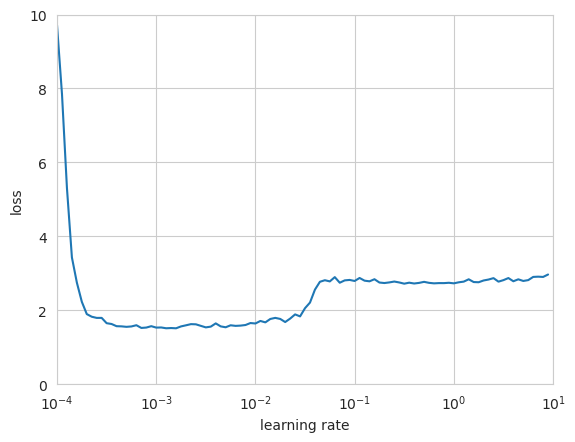

In [13]:
plt.figure()
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [14]:
def create_model():
    model = create_uncompiled_model()

    ### START CODE HERE

    initial_learning_rate = 0.0011
    
    lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=400, decay_rate=0.96, staircase=True)
    
    optimizer = optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    
    model.compile(loss=losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])   
    
    ### END CODE HERE

    return model

In [15]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0812 - mae: 7.5703
Epoch 2/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3725 - mae: 2.8295

2024-06-14 15:02:47.656420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:47.656452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1948 - mae: 2.6522
Epoch 3/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8608 - mae: 2.3196

2024-06-14 15:02:48.139395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:48.139417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:48.139431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:48.139441: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8193 - mae: 2.2744
Epoch 4/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9257 - mae: 2.3800

2024-06-14 15:02:48.615273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:48.615297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8603 - mae: 2.3138
Epoch 5/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7694 - mae: 2.2149

2024-06-14 15:02:49.121731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:49.121753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:49.121767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7355 - mae: 2.1822
Epoch 6/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9146 - mae: 2.3737

2024-06-14 15:02:49.605368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:49.605393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:49.605409: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7417 - mae: 2.1946
Epoch 7/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7103 - mae: 2.1638

2024-06-14 15:02:50.083312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:50.083339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 15:02:50.083360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:50.083369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6749 - mae: 2.1256
Epoch 8/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7778 - mae: 2.2219

2024-06-14 15:02:50.564577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:50.564614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:50.564634: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:50.564641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7042 - mae: 2.1506
Epoch 9/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5710 - mae: 2.0149

2024-06-14 15:02:51.035960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:51.035983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:51.035999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:51.036010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5953 - mae: 2.0392
Epoch 10/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6274 - mae: 2.0689

2024-06-14 15:02:51.580994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:51.581021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_13]]
2024-06-14 15:02:51.581037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:51.581049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:51.581057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7306065285304125661


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6053 - mae: 2.0499
Epoch 11/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7201 - mae: 2.1645

2024-06-14 15:02:52.088344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:52.088372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:52.088389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:52.088399: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6209 - mae: 2.0658
Epoch 12/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7244 - mae: 2.1740

2024-06-14 15:02:52.599738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:52.599767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:52.599787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5966 - mae: 2.0402
Epoch 13/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1718 - mae: 2.6382

2024-06-14 15:02:53.103715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:53.103741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:53.103755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:53.103765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8801 - mae: 2.3349
Epoch 14/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6369 - mae: 2.0733

2024-06-14 15:02:53.633590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:53.633632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 15:02:53.633647: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:53.633656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7306065285304125661
2024-06-14 15:02:53.633665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5576 - mae: 1.9955
Epoch 15/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7502 - mae: 2.2064

2024-06-14 15:02:54.143925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:54.143953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:54.143974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:54.144016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6640 - mae: 2.1150
Epoch 16/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5255 - mae: 1.9688

2024-06-14 15:02:54.663369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:54.663401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 15:02:54.663414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:02:54.663422: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7306065285304125661
2024-06-14 15:02:54.663432: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5494 - mae: 1.9934
Epoch 17/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6579 - mae: 2.0936

2024-06-14 15:02:55.170077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:55.170099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:55.170114: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:55.170123: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5680 - mae: 2.0080
Epoch 18/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5307 - mae: 1.9702

2024-06-14 15:02:55.678553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:55.678584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:55.678607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5425 - mae: 1.9855
Epoch 19/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6496 - mae: 2.0968

2024-06-14 15:02:56.226879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:56.226907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:56.226936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5512 - mae: 1.9935
Epoch 20/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6274 - mae: 2.0767

2024-06-14 15:02:56.738182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:56.738208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:56.738224: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5727 - mae: 2.0167
Epoch 21/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5513 - mae: 1.9973

2024-06-14 15:02:57.231645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:57.231670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:57.231686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:57.231695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5514 - mae: 1.9949
Epoch 22/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7377 - mae: 2.1807

2024-06-14 15:02:57.731138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:57.731163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:02:57.731179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5807 - mae: 2.0228
Epoch 23/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5944 - mae: 2.0367

2024-06-14 15:02:58.231636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:58.231670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5715 - mae: 2.0117
Epoch 24/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5387 - mae: 1.9789

2024-06-14 15:02:58.729272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:58.729296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4956 - mae: 1.9358
Epoch 25/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5573 - mae: 2.0091

2024-06-14 15:02:59.264916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:59.264938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5131 - mae: 1.9590
Epoch 26/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5023 - mae: 1.9444

2024-06-14 15:02:59.769381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:02:59.769402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:02:59.769417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:02:59.769427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5524 - mae: 1.9945
Epoch 27/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5063 - mae: 1.9515

2024-06-14 15:03:00.269471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:00.269496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:00.269511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5113 - mae: 1.9551
Epoch 28/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5177 - mae: 1.9521

2024-06-14 15:03:00.770885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 15:03:00.770910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5709 - mae: 2.0142
Epoch 29/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5239 - mae: 1.9677

2024-06-14 15:03:01.269298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:01.269323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:01.269339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:01.269353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5134 - mae: 1.9535
Epoch 30/50
10/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7244 - mae: 2.1754  

2024-06-14 15:03:01.762014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:01.762037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:01.762052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5421 - mae: 1.9836
Epoch 31/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6309 - mae: 2.0739

2024-06-14 15:03:02.285715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:02.285742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:02.285788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5423 - mae: 1.9826
Epoch 32/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5614 - mae: 2.0045

2024-06-14 15:03:02.785950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:02.785975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:02.785991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5018 - mae: 1.9413
Epoch 33/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5369 - mae: 1.9903

2024-06-14 15:03:03.282785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:03.282811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:03.282827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5204 - mae: 1.9658
Epoch 34/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5375 - mae: 1.9795

2024-06-14 15:03:03.778438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:03.778466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:03.778473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:03.778488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5072 - mae: 1.9467
Epoch 35/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5365 - mae: 1.9770

2024-06-14 15:03:04.275987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:04.276010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:04.276026: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:04.276040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5229 - mae: 1.9630
Epoch 36/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5041 - mae: 1.9401

2024-06-14 15:03:04.820123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:04.820151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:04.820168: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:03:04.820175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5039 - mae: 1.9435
Epoch 37/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5633 - mae: 2.0072

2024-06-14 15:03:05.317591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:05.317617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:05.317632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:05.317645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5609 - mae: 2.0038
Epoch 38/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5833 - mae: 2.0292

2024-06-14 15:03:05.815977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:05.816005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:05.816024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5360 - mae: 1.9775
Epoch 39/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5582 - mae: 1.9988

2024-06-14 15:03:06.312706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:06.312731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5583 - mae: 2.0024
Epoch 40/50
19/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5259 - mae: 1.9703

2024-06-14 15:03:06.852540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:06.852573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5008 - mae: 1.9437
Epoch 41/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4796 - mae: 1.9267

2024-06-14 15:03:07.355999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:07.356029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:07.356044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:07.356055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5006 - mae: 1.9435
Epoch 42/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4342 - mae: 1.8854

2024-06-14 15:03:07.852629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:07.852651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:07.852669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:07.852683: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4860 - mae: 1.9317
Epoch 43/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5386 - mae: 1.9837

2024-06-14 15:03:08.345881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:08.345908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 15:03:08.345922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:08.345930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5350 - mae: 1.9779
Epoch 44/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6437 - mae: 2.0953

2024-06-14 15:03:08.834447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:08.834474: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:08.834480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:03:08.834486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7306065285304125661
2024-06-14 15:03:08.834489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 6093082324411810899
2024-06-14 15:03:08.834506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradie

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5743 - mae: 2.0203
Epoch 45/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7088 - mae: 2.1611

2024-06-14 15:03:09.310338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:09.310362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5838 - mae: 2.0288
Epoch 46/50
 1/77 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - loss: 1.2776 - mae: 1.6802

2024-06-14 15:03:09.804472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:09.804500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5017 - mae: 1.9385
Epoch 47/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6312 - mae: 2.0820

2024-06-14 15:03:10.433901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:10.433932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 15:03:10.433948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5498 - mae: 1.9945
Epoch 48/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5406 - mae: 1.9950

2024-06-14 15:03:10.921195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:10.921258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5563 - mae: 2.0029
Epoch 49/50
20/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6122 - mae: 2.0593

2024-06-14 15:03:11.402617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:11.402643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5220 - mae: 1.9630
Epoch 50/50
21/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4889 - mae: 1.9387

2024-06-14 15:03:11.895006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:11.895029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5063 - mae: 1.9501


2024-06-14 15:03:12.376548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 15:03:12.376575: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15051977213793587426
2024-06-14 15:03:12.376581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10355272538127044633
2024-06-14 15:03:12.376613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [16]:
def compute_metrics(true_series, forecast):
    mse = metrics.mean_squared_error(true_series, forecast).numpy()
    mae = metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


2024-06-14 15:03:12.983977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


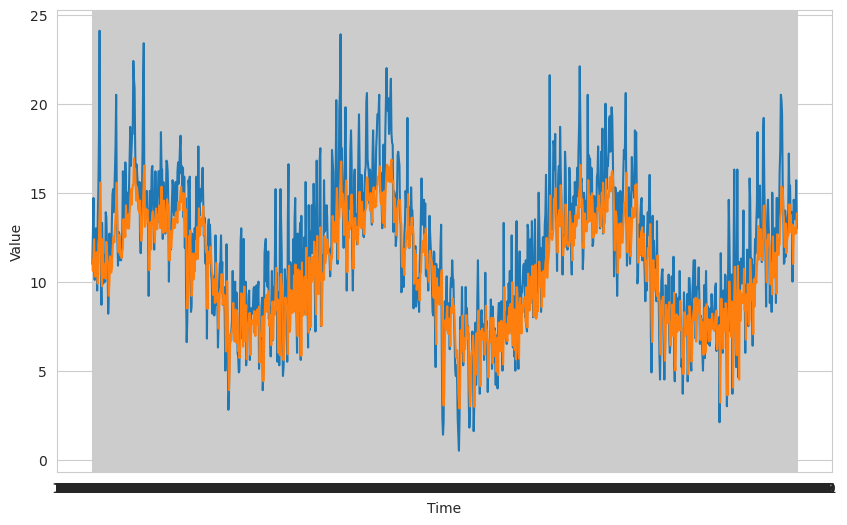

In [18]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 6.36, mae: 1.98 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in the SavedModel format which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [20]:
# # Save your model in the SavedModel format
# model.save('./saved_model/my_model')

# # Compress the directory using tar
# ! tar -czvf saved_model.tar.gz saved_model/

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**